In [ ]:
import os
import uuid
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import torch.utils.tensorboard as tensorboard
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3
from scipy.stats import entropy
import torch.nn.init as init

import tqdm
import sys

In [ ]:
# Define the critic (discriminator) and generator networks
class Critic(nn.Module):
    def __init__(self, channels_img, features):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            # Input: N x channels_img x 32 x 32
            nn.Conv2d(channels_img, features, kernel_size=4, stride=2, padding=1),  # Output: 16x16
            nn.LeakyReLU(0.2),
            self._block(features, features * 2, 4, 2, 1),  # Output: 8x8
            self._block(features * 2, features * 4, 4, 2, 1),  # Output: 4x4
        )
        self.dis = nn.Conv2d(features * 4, 1, kernel_size=4, stride=1, padding=0)  # Output: 1x1
        self.classifier = nn.Linear(512*4, 10)
        self.softmax = nn.Softmax(dim=1)

        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        x = self.critic(x)
        class_x = x.view(-1, 32*4*4*4)
        return self.dis(x), self.softmax(self.classifier(class_x))
    def init_weights(self, m):
      if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.normal_(m.weight, mean=0, std=0.02)
        if m.bias is not None:
            init.zeros_(m.bias)

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=110, out_features=384*4*4),
            nn.ReLU(inplace=True),

            Reshape((-1, 384, 4, 4)),

            nn.ConvTranspose2d(in_channels=384, out_channels=192, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=192, out_channels=96, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=96, out_channels=3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
        self.apply(self.init_weights)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.model(x)

    def init_weights(self, m):
      if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.normal_(m.weight, mean=0, std=0.02)
        if m.bias is not None:
            init.zeros_(m.bias)

def test():
    N, in_channels, H, W = 100, 3, 32, 32
    x = torch.randn((N, in_channels, H, W))
    critic = Critic(in_channels, 32)
    assert critic(x)[0].shape == (N, 1, 1, 1)
    print(critic(x)[1].shape)
    assert critic(x)[1].shape == (N, 10)
    gen = Generator()
    noise_dim = 110
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success")

test()

def save_model_state(model, epoch, filepath):
  state = {
      'state_dict': model.state_dict(),
      'epoch': epoch
  }
  torch.save(state, filepath)

torch.Size([100, 10])
Success


In [ ]:
# Hyperparams

# Constants
BATCH_SIZE = 100
IMG_SIZE = 32
CHANNELS_IMG = 3
NOISE_DIM = 110
NUM_EPOCHS = 5
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GRAD_PENALTY = 10

# Potentially loaded from saved model
learning_rate = 1e-4

# load data
print("==> Preparing data...")

data_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=data_transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

==> Preparing data...
Files already downloaded and verified


In [ ]:
# @title
# enforce lipschitz constraint
def gradient_penalty(critic, real, fake, device="cpu"):
    if real.shape != fake.shape:
        print(f'real: {real.shape}')
        print(f'fake: {fake.shape}')

    batch_size, c, h, w = real.shape
    epsilon = torch.rand((batch_size, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)

    # calculate critic scores
    mixed_scores, _ = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [ ]:
# @title
# Create random noise + fake labels
def create_random_seeding():
  batch_tensors = []
  labels = []
  for _ in range(100):
      random_part = torch.normal(mean=0, std = 1, size = (100, 1, 1)) # better to use uniform random or normal random?
      one_hot_vector = torch.zeros(10, 1, 1)
      label = torch.randint(0, 10, (1,))
      labels.append(label)
      one_hot_vector[label] = 1
      complete_tensor = torch.cat((random_part, one_hot_vector), dim=0)
      batch_tensors.append(complete_tensor)

  final_tensor = torch.stack(batch_tensors)

  return final_tensor.clone().detach().requires_grad_(True), torch.tensor(labels)

def create_sample_seeding() -> torch.Tensor:
  batch_tensors = []
  for i in range(20):
      random_part = torch.normal(mean=0, std = 1, size = (100, 1, 1)) # better to use uniform random or normal random?
      one_hot_vector = torch.zeros(10, 1, 1)
      label = i % 10
      one_hot_vector[label] = 1
      complete_tensor = torch.cat((random_part, one_hot_vector), dim=0)
      batch_tensors.append(complete_tensor)

  final_tensor = torch.stack(batch_tensors)
  return final_tensor

def get_class_accuracies(class_labels, class_predictions):
  correct = 0
  for y, y_hat in zip(class_labels, class_predictions):
    if y == y_hat.argmax(dim = -1):
      correct += 1
  return correct / len(class_labels)

def sample_images(netG, save=False, epoch=0):
  seeds = create_sample_seeding()
  seeds = seeds.to(device)
  netG.eval()
  with torch.no_grad():
    imgs = netG(seeds)

  imgs = imgs / 2 + .5
  grid = torchvision.utils.make_grid(imgs, nrow=10, padding = 4)
  grid = grid.detach().cpu().numpy()
  plt.imshow(np.transpose(grid, (1,2,0)))
  plt.xticks([])
  plt.yticks([])
  if save:
    plt.savefig(f"img_e{epoch}.png")
    np.save(f"grid_e{epoch}.npy", imgs.detach().cpu().numpy())
  else:
    plt.show()

training...: 100%|██████████| 500/500 [02:28<00:00,  3.37it/s]
[0/500]
G_Loss=9.2996 D_Loss=-4.0978
Classification Acc. (R)=0.3112 (F)=0.1215
Epoch 0           Loss C: -5.4250, Loss G: 15.4405
training...: 100%|██████████| 500/500 [02:27<00:00,  3.40it/s]
[1/500]
G_Loss=15.0961 D_Loss=-4.4940
Classification Acc. (R)=0.3932 (F)=0.1716
Epoch 1           Loss C: -4.2169, Loss G: 15.3312
training...: 100%|██████████| 500/500 [02:26<00:00,  3.41it/s]
[2/500]
G_Loss=16.7163 D_Loss=-4.1069
Classification Acc. (R)=0.4398 (F)=0.2583
Epoch 2           Loss C: -4.5360, Loss G: 20.3475
training...: 100%|██████████| 500/500 [02:26<00:00,  3.40it/s]
[3/500]
G_Loss=18.8671 D_Loss=-4.0175
Classification Acc. (R)=0.4488 (F)=0.4018
Epoch 3           Loss C: -4.3557, Loss G: 20.4396
training...: 100%|██████████| 500/500 [02:26<00:00,  3.40it/s]
[4/500]
G_Loss=21.4836 D_Loss=-3.7761
Classification Acc. (R)=0.4477 (F)=0.5509
Epoch 4           Loss C: -3.9899, Loss G: 23.3245
training...: 100%|██████████| 5

KeyboardInterrupt: ignored

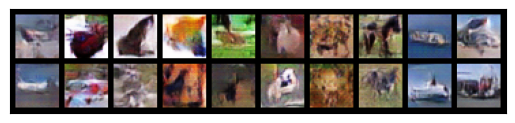

In [79]:
# initialize model
device = "cuda" if torch.cuda.is_available() else "cpu"

gen = Generator().to(device)
critic = Critic(CHANNELS_IMG, FEATURES_CRITIC).to(device)

opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_critic = optim.Adam(critic.parameters(), lr=learning_rate, betas=(0.5, 0.999))

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

# Training loop
class_criterion = nn.NLLLoss().to(device)

NUM_EPOCHS = 500

D_acc_real, D_acc_fake, D_loss, G_loss = [], [], [], []
D_c_acc_real, D_c_acc_fake = [], []

for epoch in range(NUM_EPOCHS):
  D_loss_temp, G_loss_temp = [], []
  D_c_acc_real_temp, D_c_acc_fake_temp = [], []
  gen.train()
  critic.train()
  for real, real_labels in tqdm.tqdm(loader, desc='training...', file=sys.stdout):
    real = real.to(device)
    real_labels = real_labels.to(device)
    for _ in range(CRITIC_ITERATIONS):
      # Generate fake data
      fake_seeding, fake_labels = create_random_seeding()
      fake_seeding = fake_seeding.to(device)
      fake_labels = fake_labels.to(device)
      fake = gen(fake_seeding)
      fake = fake.to(device)

      critic_real, critic_real_prediction = critic(real)
      critic_fake, critic_fake_prediction = critic(fake)
      critic_real = critic_real.reshape(-1)
      critic_fake = critic_fake.reshape(-1)

      D_c_acc_real_temp.append(get_class_accuracies(real_labels, critic_real_prediction))
      D_c_acc_fake_temp.append(get_class_accuracies(fake_labels, critic_fake_prediction))

      grad_penalty = gradient_penalty(critic, real, fake, device=device)

      classification_penalty = class_criterion(critic_real_prediction, real_labels) + class_criterion(critic_fake_prediction, fake_labels)
      # print(classification_penalty)
      loss_critic = (
          -(torch.mean(critic_real) - torch.mean(critic_fake))
          + LAMBDA_GRAD_PENALTY * grad_penalty
          + classification_penalty * .5
      )
      # print(loss_critic)
      critic.zero_grad()
      loss_critic.backward(retain_graph=True)
      opt_critic.step()

      D_loss_temp.append(loss_critic.item())

    # train generator

    c_fake, c_fpred = critic(fake)
    c_real, c_rpred = critic(real)
    c_fake = c_fake.reshape(-1)
    c_real = c_real.reshape(-1)

    class_pen = class_criterion(c_rpred, real_labels) + class_criterion(c_fpred, fake_labels)

    # print(class_pen)
    loss_gen = -torch.mean(c_fake) + class_pen * .5
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    G_loss_temp.append(loss_gen.item())

  avg_D_c_acc_real = sum(D_c_acc_real_temp) / len(D_c_acc_real_temp)
  avg_D_c_acc_fake = sum(D_c_acc_fake_temp) / len(D_c_acc_fake_temp)
  avg_D_loss = sum(D_loss_temp) / len(D_loss_temp)
  avg_G_loss = sum(G_loss_temp) / len(G_loss_temp)

  D_c_acc_real.append(avg_D_c_acc_real)
  D_c_acc_fake.append(avg_D_c_acc_fake)
  D_loss.append(avg_D_loss)
  G_loss.append(avg_G_loss)

  print("[%d/%d]\nG_Loss=%.4f D_Loss=%.4f\nClassification Acc. (R)=%.4f (F)=%.4f"
        % (epoch, NUM_EPOCHS, avg_G_loss, avg_D_loss, avg_D_c_acc_real, avg_D_c_acc_fake))
  np.save(f"G_loss_{epoch}.npy", G_loss)
  np.save(f"D_loss_{epoch}.npy", D_loss)
  np.save(f"D_c_acc_real_{epoch}.npy", D_c_acc_real)
  np.save(f"D_c_acc_fake_{epoch}.npy", D_c_acc_fake)
  save_model_state(gen, epoch, f"G_{epoch}.pth")
  save_model_state(critic, epoch, f"D_{epoch}.pth")

  sample_images(gen, save=True, epoch=epoch)

  with torch.no_grad():
    fake = gen(fixed_noise)
    print(
        f"Epoch {epoch} \
          Loss C: {loss_critic:.4f}, Loss G: {loss_gen:.4f}"
    )
    img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
    img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [85]:
current_dir = '/content'

# List all files in the current directory (excluding folders)
files = [f for f in os.listdir(current_dir) if os.path.isfile(os.path.join(current_dir, f))]

print(len(files))

569


In [86]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/my_files.zip', 'w') as zipf:
    for file in files:
        zipf.write(file)

In [83]:
from google.colab import files

files.download('my_files.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>